Import necessary libraries

In [10]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
from scipy.stats import binom_test
from termcolor import colored
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import beta
import warnings
from IPython.display import set_matplotlib_formats
from google.colab import files
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

Load annotator's answers.
Each row include:
1.   time - timestamp of answer
2.   role - role of annotator that reflect detection scenario
3.   annotator_id - Telegram identifier of annotator
4.   analysed_account_id - VKontakte id of analysed account
5.   answer - annotator's answer that we used as human-based labels
6.   ground_truth_label - real label
7.   bot_qaulity - quality of bot (NaN for analysed accounts of real users)

We also remove IDN answers.

In [11]:
data = pd.read_csv("https://raw.githubusercontent.com/guardeec/datasets/main/MKVKTT2021/answers.csv")
print("Number of annotators:", len(data["annotator_id"].unique()))
print("Number of answers:", len(data))
data = data[data["answer"]!="IDN"]
print("Number of answers without IDN:", len(data))
data.head(10)

Number of annotators: 62
Number of answers: 2877
Number of answers without IDN: 2434


,time,role,annotator_id,analysed_account_id,answer,ground_truth_label,bot_quality
0,1.637044e+09,BOTS+RANDOM,889969266,40117134,BOT,USER,NaN
1,1.637044e+09,BOTS+GROUPS_SHIFTED,591258635,28736664,USER,USER,NaN
2,1.637044e+09,BOTS+RANDOM,889969266,496521753,BOT,USER,NaN
3,1.637044e+09,BOTS+RANDOM,889969266,459395662,BOT,BOT,MID
4,1.637044e+09,BOTS+GROUPS_SHIFTED,591258635,481138281,BOT,USER,NaN
5,1.637044e+09,BOTS+RANDOM,889969266,176831746,BOT,BOT,LIVE
6,1.637044e+09,BOTS+GROUPS_SHIFTED,1970646870,582789441,BOT,BOT,LOW
7,1.637044e+09,BOTS+GROUPS_SHIFTED,591258635,44186315,USER,USER,NaN
8,1.637044e+09,BOTS+GROUPS_SHIFTED,591258635,138470948,USER,USER,NaN
9,1.637044e+09,BOTS+GROUPS_SHIFTED,591258635,574868829,BOT,BOT,LOW


# Hyptheses tests.

**Hypothesis - annotators can detect bot**:
*   H0 (trying to reject) - distribution eq. to binominal distribution with probability of success p<=0.5 (random or worse = annotators **can not** detect bots)
*   H1 (alternative) - distribution eq. to binominal distribution with probability of success p>0.5 (better than random = annotators **can** detect bots)

For test we use binominal test with expected probability of success <= 0.5:
*   if p_value < 0.05, we reject H0 (can detect) and highlight with red
*   if p_value >= 0.05, we not reject H0 (can not detect) и highlight with blue

DATASET: ALL DATA
   ---
   ALL QUALITIES
   CORRECT: 1585 | INCORRECT:849 | p_value: 2.9485478189392345e-51 | confidence interval: 0.635 - 0.667
   ---
    LOW
   CORRECT: 245 | INCORRECT:48 | p_value: 2.7363006497963752e-33 | confidence interval: 0.798 - 0.869
   ---
    MID
   CORRECT: 413 | INCORRECT:110 | p_value: 1.4512886146690762e-42 | confidence interval: 0.759 - 0.817
   ---
    HIGH
   CORRECT: 116 | INCORRECT:168 | p_value: 0.9991927645640154 | confidence interval: 0.362 - 0.457
   ---
    LIVE
   CORRECT: 232 | INCORRECT:179 | p_value: 0.005116005533682311 | confidence interval: 0.524 - 0.604

DATASET: BOTS+GROUPS_SHIFTED
   ---
   ALL QUALITIES
   CORRECT: 345 | INCORRECT:112 | p_value: 5.71085410984776e-29 | confidence interval: 0.72 - 0.786
   ---
    LOW
   CORRECT: 35 | INCORRECT:9 | p_value: 5.3022333133867465e-05 | confidence interval: 0.68 - 0.877
   ---
    MID
   CORRECT: 52 | INCORRECT:16 | p_value: 7.037077887988732e-06 | confidence interval: 0.671 - 0.838
   -

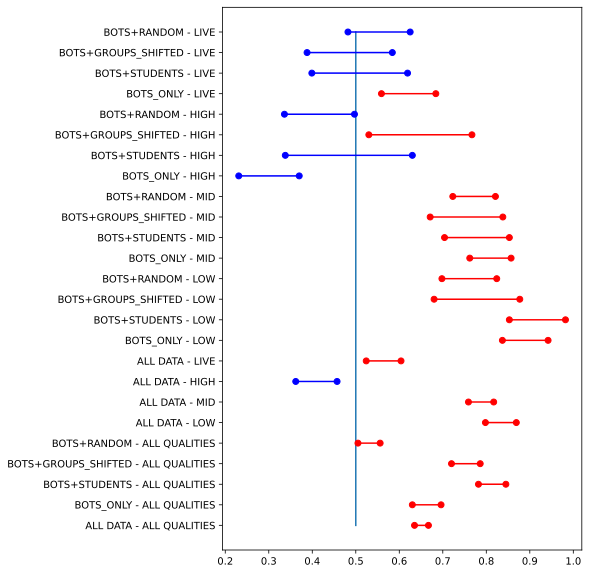

In [12]:
DATA_QUALITY = ["LOW", "MID", "HIGH", "LIVE"]
DATASET = ['BOTS+GROUPS_SHIFTED', 'BOTS+RANDOM', 'BOTS_ONLY', 'BOTS+STUDENTS']
warnings.filterwarnings('ignore')
set_matplotlib_formats('svg')

from statsmodels.stats.proportion import proportion_confint
# function for calculation intervals
def binom_interval(success, total, confidence_level=0.95, round_value=3):
        interval = proportion_confint(success, total, alpha=0.10, method='wilson')
        return [round(interval[0], round_value), round(interval[1], round_value)]

# function for binom test where we also process answers 
def do_test_H(data_slice_quality, name, c_intervals_results):
    
    # we create array of answers were 1 is correct and 0 is uncorrect bot detection
    data_slice_quality["b_res"] = data_slice_quality.apply(lambda row:
                                  1 if (("BOT"==row['answer'] and "BOT"==row["ground_truth_label"]) or ("USER"==row['answer'] and "USER"==row["ground_truth_label"]))
                                  else 0
                                  , axis=1)
    # count correct, incorrect and probabilities
    correct = sum(data_slice_quality["b_res"])
    incorrect = len(data_slice_quality["b_res"]) - correct
    prob = [(correct+incorrect)/2, (correct+incorrect)/2]

    #do binom test
    p_value = binom_test([correct, incorrect], p=0.5, alternative='greater')
    
    #calculate intervals
    c_interval = binom_interval(correct, correct + incorrect, confidence_level=0.95, round_value=3)
    
    # print results
    res_string = "   CORRECT: " + str(correct) + \
                 " | INCORRECT:" + str(incorrect) + \
                 " | p_value: " + str(p_value) + \
                 " | confidence interval: " + str(c_interval[0]) + " - " + str(c_interval[1])
    
    #save intervals for chart
    c_intervals_results['category'].append(name)
    c_intervals_results['upper'].append(c_interval[1])
    c_intervals_results['lower'].append(c_interval[0])
    
    #color results
    if p_value > 0.05:
        print(colored(res_string, 'blue'))
    else:
        print(colored(res_string, 'red'))
    
# do tests for each quality
def do_test_by_quality (data, qualities, c_intervals_results):
    for quality in qualities:
        print("   ---")
        print("   ", quality)
        data_slice_quality = data[data["bot_quality"] == quality]
        do_test_H(data_slice_quality, "ALL DATA - " + quality, c_intervals_results)

# do tests for each role     
def do_test_by_role (data, datasets, c_intervals_results):
    for dataset_name in datasets:
        print("\nDATASET:", dataset_name)
        print("   ---")
        print("   ALL QUALITIES")
        data_slice = data[data["role"]==dataset_name]
        do_test_H(data_slice, dataset_name + " - ALL QUALITIES", c_intervals_results)
        #each role we also split on quality
        for quality in DATA_QUALITY:
                print("   ---")
                print("   ", quality)
                data_slice_quality = data_slice[data_slice["bot_quality"] == quality]
                do_test_H(data_slice_quality,  dataset_name + " - " + quality, c_intervals_results)
            
# draw interval chart
def plot_intervals (c_intervals_results):
    df_intervals = pd.DataFrame(c_intervals_results)
    figure(figsize=(10, 10), dpi=300)
    plt.plot((0.5,0.5),(0, len(df_intervals)-1))

    # we use this for ordering: 
    #     fist 4 blocks ordered by quality and role, 
    #     next block is quality on all data,
    #     next block is all qualities on different roles
    #     last result is all data  
    def category_order(c):
        return {
            "BOTS+RANDOM - LIVE": 24,
            "BOTS+GROUPS_SHIFTED - LIVE": 23,
            "BOTS+STUDENTS - LIVE": 22,
            "BOTS_ONLY - LIVE": 21,

            "BOTS+RANDOM - HIGH": 20,
            "BOTS+GROUPS_SHIFTED - HIGH": 19, 
            "BOTS+STUDENTS - HIGH": 18,
            "BOTS_ONLY - HIGH": 17,

            "BOTS+RANDOM - MID": 16,
            "BOTS+GROUPS_SHIFTED - MID": 15,
            "BOTS+STUDENTS - MID": 14,
            "BOTS_ONLY - MID": 13,

            "BOTS+RANDOM - LOW": 12,
            "BOTS+GROUPS_SHIFTED - LOW": 11,
            "BOTS+STUDENTS - LOW": 10,
            "BOTS_ONLY - LOW": 9,

            "ALL DATA - LIVE": 8,
            "ALL DATA - HIGH": 7,
            "ALL DATA - MID": 6,
            "ALL DATA - LOW": 5,

            "BOTS+RANDOM - ALL QUALITIES": 4,
            "BOTS+GROUPS_SHIFTED - ALL QUALITIES": 3,
            "BOTS+STUDENTS - ALL QUALITIES": 2,
            "BOTS_ONLY - ALL QUALITIES": 1,

            "ALL DATA - ALL QUALITIES": 0,
        }[c]
    df_intervals = df_intervals.assign(f = df_intervals['category'].\
                                       map(lambda c: category_order(c))).\
                                        sort_values('f').drop('f', axis=1)
    for lower,upper,y in zip(df_intervals['lower'],df_intervals['upper'],range(len(df_intervals))):
        color = "blue"
        if lower > 0.5:
             color="red"
        plt.plot((lower,upper),(y,y),'ro-',color=color)
    plt.yticks(range(len(df_intervals)),list(df_intervals['category']))
    plt.subplots_adjust(left=0.4)
    plt.savefig("res.pdf")
    # uncomment if you want to download interval chart
    #files.download("res.pdf") 

# run all these functions
print("DATASET: ALL DATA")
print("   ---")
print("   ALL QUALITIES")
c_intervals_results = {'category': [], 'lower': [], 'upper': []}

do_test_H(data, "ALL DATA - ALL QUALITIES", c_intervals_results)
do_test_by_quality(data, DATA_QUALITY, c_intervals_results)
do_test_by_role(data, DATASET, c_intervals_results)
plot_intervals(c_intervals_results)

# Hypothetical classifier evaluation.

Calculate efficiency metrics:

1. TPR - true positive rate (decribe ability to detect bot)
2. TNR - true positive rate (decribe ability to detect user)
3. balanced accuracy - integral measure

In [13]:
# calculate TPR and TNR for slice of bots with specific quality and role
def get_TPR(data_slice_y, prec):
    true_labels = list(map(lambda row: 1 if row=="BOT" else 0, data_slice_y["ground_truth_label"]))
    predicted_labels = list(map(lambda row: 1 if row=="BOT" else 0, data_slice_y["answer"]))
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    return round(tp / (tp + fn),prec)

def get_TNR(data_slice_y, prec):
    true_labels = list(map(lambda row: 1 if row=="BOT" else 0, data_slice_y["ground_truth_label"]))
    predicted_labels = list(map(lambda row: 1 if row=="BOT" else 0, data_slice_y["answer"]))
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    return round(tn / (tn + fp), prec)

# calculate Balanced accuracy
def get_BACC(tpr, tnr, prec):
    return round((tpr + tnr) / 2, prec)

# add measures to result dict
def add_to_res(res, dataset_name, quality, tpr, tnr, prec):
    res[dataset_name][quality]["tpr"] = tpr
    res[dataset_name][quality]["tnr"] = tnr
    res[dataset_name][quality]["bacc"] = get_BACC(tpr, tnr, prec)

# do test for samples splitted by role
def do_test_C_by_roles_qualities (data, datasets, qualities, results, prec):
    tpr = get_TPR(data, prec)
    tnr = get_TNR(data, prec)
    add_to_res(results, "ALL DATASETS", "ALL QUALITIES", tpr, tnr, prec)
    for quality in qualities:
              data_slice_by_quality = data[data["bot_quality"] == quality]     
              tpr = get_TPR(data_slice_by_quality, prec)
              add_to_res(results, "ALL DATASETS", quality, tpr, tnr, prec)

    for role in datasets:
      data_slice_by_role = data[data["role"] == role]
      tpr = get_TPR(data_slice_by_role, prec)     
      tnr = get_TNR(data_slice_by_role, prec)
      add_to_res(results, role, "ALL QUALITIES", tpr, tnr, prec)
      for quality in qualities:
              data_slice_by_role_and_quality = data_slice_by_role[data_slice_by_role["bot_quality"] == quality]     
              tpr = get_TPR(data_slice_by_role_and_quality, prec)
              add_to_res(results, role, quality, tpr, tnr, prec)

datasets_results = {
        "ALL DATASETS":{"ALL QUALITIES":{}, "LOW":{}, "MID":{}, "HIGH":{}, "LIVE":{}},
        'BOTS+GROUPS_SHIFTED':{"ALL QUALITIES":{}, "LOW":{}, "MID":{}, "HIGH":{}, "LIVE":{}}, 
        'BOTS+RANDOM':{"ALL QUALITIES":{}, "LOW":{}, "MID":{}, "HIGH":{}, "LIVE":{}}, 
        'BOTS_ONLY':{"ALL QUALITIES":{}, "LOW":{}, "MID":{}, "HIGH":{}, "LIVE":{}}, 
        'BOTS+STUDENTS':{"ALL QUALITIES":{}, "LOW":{}, "MID":{}, "HIGH":{}, "LIVE":{}}
}
do_test_C_by_roles_qualities (data, DATASET, DATA_QUALITY, datasets_results, prec=3)

acc = pd.DataFrame (datasets_results).applymap (lambda x : x['bacc'])
tpr = pd.DataFrame (datasets_results).applymap (lambda x : x['tpr'])
tnr = pd.DataFrame (datasets_results).applymap (lambda x : x['tnr'])

Print table with balaced accuracy measures

In [14]:
acc

,ALL DATASETS,BOTS+GROUPS_SHIFTED,BOTS+RANDOM,BOTS_ONLY,BOTS+STUDENTS
ALL QUALITIES,0.647,0.752,0.522,NaN,0.812
LOW,0.732,0.817,0.578,NaN,0.936
MID,0.708,0.802,0.582,NaN,0.856
HIGH,0.518,0.749,0.401,NaN,0.704
LIVE,0.595,0.662,0.472,NaN,0.717


Print table with FPR

In [15]:
tpr

,ALL DATASETS,BOTS+GROUPS_SHIFTED,BOTS+RANDOM,BOTS_ONLY,BOTS+STUDENTS
ALL QUALITIES,0.666,0.665,0.655,0.664,0.700
LOW,0.836,0.795,0.767,0.901,0.947
MID,0.790,0.765,0.776,0.814,0.788
HIGH,0.408,0.659,0.414,0.296,0.483
LIVE,0.564,0.485,0.555,0.623,0.509


Print table with TNR

In [16]:
tnr

,ALL DATASETS,BOTS+GROUPS_SHIFTED,BOTS+RANDOM,BOTS_ONLY,BOTS+STUDENTS
ALL QUALITIES,0.627,0.839,0.389,NaN,0.925
LOW,0.627,0.839,0.389,NaN,0.925
MID,0.627,0.839,0.389,NaN,0.925
HIGH,0.627,0.839,0.389,NaN,0.925
LIVE,0.627,0.839,0.389,NaN,0.925
